In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6KPMI1mLdrItaVuJSsaBloZZPaA10lQgWSBh-vuYzf01MSA2_xQ6E
Mounted at /content/drive


# Dependencies

In [ ]:
import torch
import cv2
import torchvision
import torchvision.datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from glob import glob
import os

In [ ]:
TEST_DIR="/content/drive/MyDrive/final_year_project/outputs/patches7/test"
TRAIN_DIR="/content/drive/MyDrive/final_year_project/outputs/patches7/train"
VAL_DIR="/content/drive/MyDrive/final_year_project/outputs/patches7/val"

In [ ]:
classes=["covid","normal","pneumonia"]

# Patch Extraction

In [ ]:

def frac_eq_to(image, value=0):
    return (image == value).sum() / float(np.prod(image.shape))

def extract_patches(image, patchshape, overlap_allowed=0.5, cropvalue=None,
                    crop_fraction_allowed=0.1):
    """
    Given an image, extract patches of a given shape with a certain
    amount of allowed overlap between patches, using a heuristic to
    ensure maximum coverage.
    If cropvalue is specified, it is treated as a flag denoting a pixel
    that has been cropped. Patch will be rejected if it has more than
    crop_fraction_allowed * prod(patchshape) pixels equal to cropvalue.
    Likewise, patches will be rejected for having more overlap_allowed
    fraction of their pixels contained in a patch already selected.
    """
    jump_cols = int(patchshape[1] * overlap_allowed)
    jump_rows = int(patchshape[0] * overlap_allowed)
    
    # Restrict ourselves to the rectangle containing non-cropped pixels
    if cropvalue is not None:
        rows, cols = np.where(image != cropvalue)
        rows.sort(); cols.sort()
        active =  image[rows[0]:rows[-1], cols[0]:cols[-1]]
    else:
        active = image

    rowstart = 0; colstart = 0

    # Array tracking where we've already taken patches.
    covered = np.zeros(active.shape, dtype=bool)
    patches = []

    while rowstart < active.shape[0] - patchshape[0]:
        # Record whether or not e've found a patch in this row, 
        # so we know whether to skip ahead.
        got_a_patch_this_row = False
        colstart = 0
        while colstart < active.shape[1] - patchshape[1]:
            # Slice tuple indexing the region of our proposed patch
            region = (slice(rowstart, rowstart + patchshape[0]),
                      slice(colstart, colstart + patchshape[1]))
            
            # The actual pixels in that region.
            patch = active[region]

            # The current mask value for that region.
            cover_p = covered[region]
            if cropvalue is None or \
               frac_eq_to(patch, cropvalue) <= crop_fraction_allowed and \
               frac_eq_to(cover_p, True) <= overlap_allowed:
                # Accept the patch.
                patches.append(patch)
                
                # Mask the area.
                covered[region] = True
                
                # Jump ahead in the x direction.
                colstart += jump_cols
                got_a_patch_this_row = True
                #print "Got a patch at %d, %d" % (rowstart, colstart)
            else:
                # Otherwise, shift window across by one pixel.
                colstart += 1

        if got_a_patch_this_row:
            # Jump ahead in the y direction.
            rowstart += jump_rows
        else:
            # Otherwise, shift the window down by one pixel.
            rowstart += 1

    # Return a 3D array of the patches with the patch index as the first
    # dimension (so that patch pixels stay contiguous in memory, in a 
    # C-ordered array).
    return np.concatenate([pat[np.newaxis, ...] for pat in patches], axis=0)


In [ ]:
def func(img):
  return np.average(img)

def save_patches(patches,class_name,file_name):
  patches=sorted(patches,key=func,reverse=True)[:10]
  patch_dir=os.path.join(PATCHES_DIR,cls)
  for i in tqdm(range(10)):
    file_path=patch_dir+"/"+file_name[:-11]+"_patch"+str(i)+".png"
    
    img=(patches[i][:, :, 0] * 255.).numpy().astype(np.uint8)
    print(file_path)
    # cv2.resize(patches[i],(1024,1024))
    cv2.imwrite(file_path,img)
      

In [ ]:
# for cls in classes:
#   for img_path in tqdm(glob(os.path.join(SEGMENTATION_DIR,cls,"*"))):
    
#     img=Image.open(img_path)
#     img=np.asarray(img)
#     img=cv2.resize(img,(1024,1024))
    
#     patches=extract_patches(img,(224,224))
#     patches=torch.from_numpy(patches)
#     file_name=os.path.basename(img_path)
    
#     save_patches(patches,cls,file_name)

# Dataloader and Transforms

In [ ]:
BATCH_SIZE=20

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(1024, 1024)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.3753], std=[0.2937]),
    torchvision.transforms.Grayscale(num_output_channels=1)
    
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(1024, 1024)),
    torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.3725], std=[0.3040]),

    torchvision.transforms.Grayscale(num_output_channels=1)
])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(1024, 1024)),
    torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.3992], std=[0.3173]),

    torchvision.transforms.Grayscale(num_output_channels=1)
])

In [ ]:

train_ds=ImageFolder(root=TRAIN_DIR,transform=train_transform,)
test_ds=ImageFolder(root=TEST_DIR,transform=test_transform)
val_ds=ImageFolder(root=VAL_DIR,transform=val_transform)

In [ ]:
print(train_ds.class_to_idx)
print(test_ds.classes)
print(val_ds.classes)

{'covid': 0, 'normal': 1, 'pneumonia': 2}
['covid', 'normal', 'pneumonia']
['covid', 'normal', 'pneumonia']


In [ ]:

train_dl=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True)
test_dl=DataLoader(test_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=BATCH_SIZE,num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print('Number of training batches', len(train_dl))
print('Number of test batches', len(test_dl))
print('Number of validation batches', len(val_dl))

Number of training batches 1047
Number of test batches 129
Number of validation batches 129


# Load Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-6,weight_decay=1e-8)

In [ ]:
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:

resnet18.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Preview

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


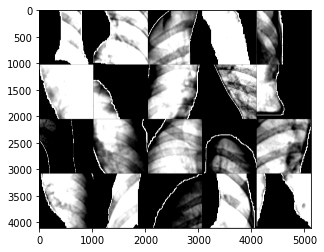

labels:  tensor([1, 1, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 2, 2, 1])


In [ ]:

dataiter = iter(train_dl)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid(images,nrow=5))
print ("labels: ",labels)

# Load Saved Model

In [ ]:
MODEL_PATH="/content/drive/MyDrive/final_year_project/resnet18_20_4.pth"

In [ ]:
current_epochs=0

Run the cell below if you use saved model

In [ ]:
checkpoint = torch.load(MODEL_PATH)
resnet18.load_state_dict(checkpoint['model_state_dict'])
current_epochs=checkpoint['epoch']
loss_fn=checkpoint['loss']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
print(current_epochs)

7


# Training & Testing

In [ ]:
def performance(model, dataloader, optimizer, criterion, val_data):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
            # print("correct is ",val_running_correct)
        val_loss = val_running_loss/len(dataloader)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
        return val_loss, val_accuracy

In [ ]:
train_loss_values=[]
train_acc_values=[]
val_loss_values=[]
val_acc_values=[]

Run the cell below ,if you are using saved model

In [ ]:
train_loss_values=checkpoint['train_loss_values']
train_acc_values=checkpoint['train_acc_values']
val_loss_values=checkpoint['val_loss_values']
val_acc_values=checkpoint['val_acc_values']

In [ ]:

EPOCHS=20

In [ ]:

for epoch in range(EPOCHS):
  running_loss=0.0
  correct=0
  total=0
  print("\nEpoch ",current_epochs+epoch+1 )
  loop=tqdm(enumerate(train_dl,0),total=len(train_dl))
  for i,data in loop:
    resnet18.train()
    inputs,labels=data
    inputs=inputs.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    
    
    outputs=resnet18(inputs)
    loss=loss_fn(outputs,labels)

    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total+=labels.size(0)
    _,predicted=torch.max(outputs,1)
    # print(predicted, labels)
    
    loop.set_postfix(loss=loss.item())
    correct += (predicted == labels).sum().item()
    # print("correct is ",correct)
    # if i % 2000 == 1999:    # print every 2000 mini-batches
    #         print('[%d, %5d] loss: %.3f' %
    #               (epoch + 1, i + 1, running_loss / 2000))
    #         running_loss = 0.0
    
  accuracy= 100 * correct / total
  train_acc_values.append(accuracy)
  print("\n\tTraining Accuracy : ", accuracy)
  train_loss_values.append(running_loss/len(train_dl))
  print("\tTraining loss : ", running_loss/len(train_dl))

  val_loss,val_acc=performance(resnet18,val_dl,optimizer,loss_fn,val_ds)
  
  print("\tValidation accuracy  : ", val_acc)
  print("\tValidation loss : ", val_loss)

  val_loss_values.append(val_loss)
  val_acc_values.append(val_acc)
  print("Saving model...")
  torch.save({
            'epoch': current_epochs+epoch+1,
            'model_state_dict': resnet18.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'train_acc_values':train_acc_values,
            'val_acc_values':val_acc_values,
            'train_loss_values':train_loss_values,
            'val_loss_values':val_loss_values
            }, MODEL_PATH)
print('Finished Training')


In [ ]:
current_epochs=current_epochs+epoch+1
print(current_epochs)

8


## Performance

In [ ]:
test_loss,test_acc=performance(resnet18,test_dl,optimizer,loss_fn,test_ds)
print("\nFinal accuracy : ",test_acc)
print("Final loss : ",test_loss)

In [ ]:
plt.plot(train_loss_values,label="Train")
plt.plot(val_loss_values, label="Val")
plt.xticks([i for i in range(current_epochs)],labels=[i+1 for i in range(current_epochs)])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')

In [ ]:
plt.plot(train_acc_values,label="Train")
plt.plot(val_acc_values,label="Val")
plt.xticks([i for i in range(current_epochs)],labels=[i+1 for i in range(current_epochs)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')

## Testing

In [ ]:
dataiter = iter(test_dl)
for i in range(120):
  dataiter.next()
images, labels = dataiter.next()
print(labels)
print (images.shape)
imshow(torchvision.utils.make_grid(images,nrow=5))


In [ ]:
torch.cuda.empty_cache()

In [ ]:
resnet18.eval()
print(images.shape)
outputs=resnet18(images.to(device))
_, predicted = torch.max(outputs, 1)

print(predicted)

torch.Size([10, 1, 1024, 1024])
tensor([0, 1, 2, 0, 0, 0, 0, 0, 0, 2], device='cuda:0')


In [ ]:
def func(img):
  return np.average(img)

def get_patches_as_images(patches):
  patches=sorted(patches,key=func,reverse=True)[:10]
  for i in range(len(patches)):
    patches[i]=Image.fromarray(patches[i])
    patches[i]=patches[i].resize((1024,1024))
    patches[i]=test_transform(patches[i])
    patches[i]=patches[i].numpy()
    # patches[i]=np.array(patches[i])
    print(patches[i])
  
  results=torch.tensor(patches,dtype=torch.float)
  print(results.shape)
  
  results=results.view(10,1,1024,1024)
  
  print(results.shape)
  return results
def get_label(id):
  print(classes,id)
  return classes[id]

[[[229 229 229]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[180 180 180]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 77  77  77]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(1024, 1024, 3)
[[[229 229 229]
  [172 172 172]
  [ 57  57  57]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[217 217 217]
  [163 163 163]
  [ 54  54  54]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[192 192 192]
  [144 144 144]
  [ 48  48  48]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[108 108 108]
  [ 81  81  81]
  [ 

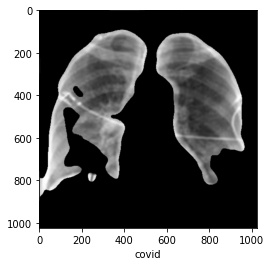

In [ ]:

resnet18.eval()

img_test=cv2.imread("/content/drive/MyDrive/final_year_project/outputs/segmentation/covid/COVID-1239_predict.png")
print(img_test)
img_test=cv2.resize(img_test,(1024,1024))
print(img_test.shape)

patches=extract_patches(img_test,(224,224))
print(patches[0])
# plt.imshow(patches[1],cmap='gray')
patches=get_patches_as_images(patches)
print(patches.shape)
print(patches[0].shape)
plt.imshow(np.squeeze(patches[1].numpy()),cmap='gray')
with torch.no_grad():
  outputs=resnet18(patches.to(device))
  print(outputs)
  _,predicted = torch.max(outputs,1)
  print(predicted)
  out=torch.mode(predicted,0)[0]
  print(out)
  plt.imshow(img_test,cmap='gray')
  plt.xlabel(get_label(out))
  print(get_label(out))

torch.Size([1, 1024, 1024])


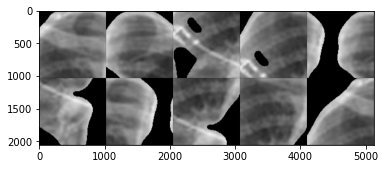

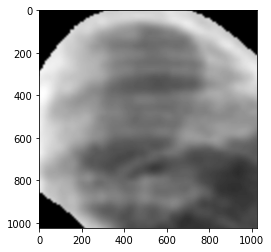

In [ ]:
print(patches[0].shape)
imshow(torchvision.utils.make_grid(patches,nrow=5))
plt.imshow(np.squeeze(patches[1]).numpy(),cmap='gray')

In [ ]:
ROOT_DIR="/content/drive/MyDrive/chest-xray-dataset"

In [ ]:
PATCH_DIR="/content/drive/MyDrive/final_year_project/outputs/patches7"

In [ ]:
for patch in tqdm(os.listdir(os.path.join(PATCH_DIR,"val","pneumonia"))):
  if  "Normal" in patch or "COVID" in patch:
    print(os.path.join(PATCH_DIR,"val","pneumonia",patch))

100%|██████████| 860/860 [00:00<00:00, 900200.01it/s]


In [ ]:
images=glob(os.path.join("/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia","*"))

In [ ]:
for i in images :
  print(i)

/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-172_patch15.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-168_patch11.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-176_patch2.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-189_patch4.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-179_patch13.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-161_patch3.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-167_patch12.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-139_patch19.png
/content/drive/MyDrive/final_year_project/outputs/patches7/val/pneumonia/Viral Pneumonia-177_patch18.png
/content/drive/MyDrive/final_year_project/outputs/patches7